In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier

# PreReport

In [67]:
class_1 = np.array([[1,2],[2,3],[3,3],[4,5],[5,5]])
class_2 = np.array([[1,0],[2,1],[3,1],[3,2],[5,3],[6,5]])

mean_1 = class_1.mean(axis=0).round(2)
mean_2 = class_2.mean(axis=0).round(2)
mean_total = ((mean_1 * 5 + mean_2 *6 )/11).round(2)
print('mean_1:\n',mean_1)
print('mean_2:\n',mean_2)
print('mean_total:\n',mean_total)

s_w = np.matmul((class_1 - mean_1).T,class_1 - mean_1) + np.matmul((class_2 - mean_2).T,class_2 - mean_2)
print('Sw:\n',s_w)

n_1 = 5
n_2 = 6
s_b = np.matmul((mean_1 - mean_total ).reshape(2,1),(mean_1 - mean_total).reshape(1,2))*n_1
+ np.matmul((mean_2 - mean_total ).reshape(2,1),(mean_2 - mean_total).reshape(1,2))*n_2
print('Sb:\n',s_b)

s_inv_w_b = np.matmul(np.linalg.inv(s_w) , s_b)
print('s_inv_w_b:\n',s_inv_w_b)

values, vectors = np.linalg.eig(s_inv_w_b)
print('eigen vectors:\n',vectors)

mean_1:
 [3.  3.6]
mean_2:
 [3.33 2.  ]
mean_total:
 [3.18 2.73]
Sw:
 [[27.3334 24.    ]
 [24.     23.2   ]]
Sb:
 [[ 0.162  -0.783 ]
 [-0.783   3.7845]]
s_inv_w_b:
 [[ 0.38789794 -1.87484003]
 [-0.43502373  2.10261468]]
eigen vectors:
 [[-0.97926042  0.66552292]
 [-0.2026056  -0.74637742]]


# Report

In [2]:
# load data
surprise_images = []
happy_images = []
for file in glob.glob('D:/Uni-02-03(1)/CVML LAB/Labs/Lab3/surprise-20231010T232852Z-001/surprise/*.png'):
    surprise_images.append(cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2GRAY))

for file in glob.glob('D:/Uni-02-03(1)/CVML LAB/Labs/Lab3/happy-20231010T232842Z-001/happy/*.png'):
    happy_images.append(cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2GRAY))


In [3]:
Y_surprise = [0] * 88
Y_happy = [1] * 85

In [4]:
X_train_surprise, X_test_surprise, y_train_surprise, y_test_surprise = train_test_split(surprise_images, Y_surprise, test_size=38, random_state=40)
X_train_happy, X_test_happy, y_train_happy, y_test_happy = train_test_split(happy_images, Y_happy, test_size=35, random_state=40)

In [5]:
X_train =  X_train_surprise  + X_train_happy
X_test =  X_test_surprise  + X_test_happy

y_train =  np.array(y_train_surprise  + y_train_happy)
y_test =  np.array(y_test_surprise  + y_test_happy)

# reshape iamges
X_train = np.array(X_train).reshape(100,-1)
X_test = np.array(X_test).reshape(73,-1)

In [6]:
# fit PCA
X = X_train
pca = PCA(n_components=50)
X_train_reduced = pca.fit_transform(X)
# reconstructed = pca.inverse_transform(X_new)
X_test_reduced = pca.transform(X_test)
# reconstructed = pca.inverse_transform(new_test)

In [7]:
X_train_reduced.shape

(100, 50)

In [8]:
# LDA
clf = LinearDiscriminantAnalysis()
clf.fit(X_train_reduced, y_train)

LinearDiscriminantAnalysis()

In [14]:
fisher_vectors = clf.scalings_
print('Number of Fisher Vectors:',len(fisher_vectors))
fisher_vectors = (fisher_vectors/np.linalg.norm(fisher_vectors)) * np.mean(np.linalg.norm(X_train_reduced , axis=0))

fisher_recun = pca.inverse_transform(fisher_vectors.T)

Number of Fisher Vectors: 50


#### As you see we have 50 fisher vectors.

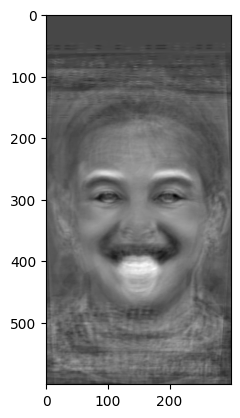

In [10]:
plt.imshow(fisher_recun.reshape(600,300) , cmap = 'gray')

#### Fisher Face shows the most discriminant areas in the Face like mouth and eyebrows.

In [11]:
# LDA with PCs 1 to 50
def LDA_PCA(n_comps):
    # fit PCA
    X = X_train
    pca = PCA(n_components=n_comps)
    X_train_reduced = pca.fit_transform(X)
    X_test_reduced = pca.transform(X_test)
    # LDA
    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train_reduced, y_train)
    y_train_preds = clf.predict(X_train_reduced)
    y_test_preds = clf.predict(X_test_reduced)
    train_error = mean_squared_error(y_train , y_train_preds)
    test_error = mean_squared_error(y_test , y_test_preds)
    return train_error , test_error

In [12]:
def KNN_PCA(n_nei , n_comps):
    # fit PCA
    X = X_train
    pca = PCA(n_components=n_comps)
    X_train_reduced = pca.fit_transform(X)
    X_test_reduced = pca.transform(X_test)
    # KNN
    neigh = KNeighborsClassifier(n_neighbors=n_nei)
    neigh.fit(X_train_reduced, y_train)
    y_train_preds = neigh.predict(X_train_reduced)
    y_test_preds = neigh.predict(X_test_reduced)
    train_error = mean_squared_error(y_train , y_train_preds)
    test_error = mean_squared_error(y_test , y_test_preds)
    return train_error , test_error

In [36]:
number_comps = [5,10,15,25,30,35,40,45,50]
LDA_test_error = []
LDA_train_error = []

KNN1_test_error = []
KNN1_train_error = []

KNN3_test_error = []
KNN3_train_error = []

KNN5_test_error = []
KNN5_train_error = []

for num_comps in number_comps:
    train_error , test_error = LDA_PCA(num_comps)
    LDA_test_error.append(test_error)
    LDA_train_error.append(train_error)
    
    train_error , test_error = KNN_PCA(1,num_comps)
    KNN1_test_error.append(test_error)
    KNN1_train_error.append(train_error)
    
    train_error , test_error = KNN_PCA(3,num_comps)
    KNN3_test_error.append(test_error)
    KNN3_train_error.append(train_error)
    
    train_error , test_error = KNN_PCA(5,num_comps)
    KNN5_test_error.append(test_error)
    KNN5_train_error.append(train_error)

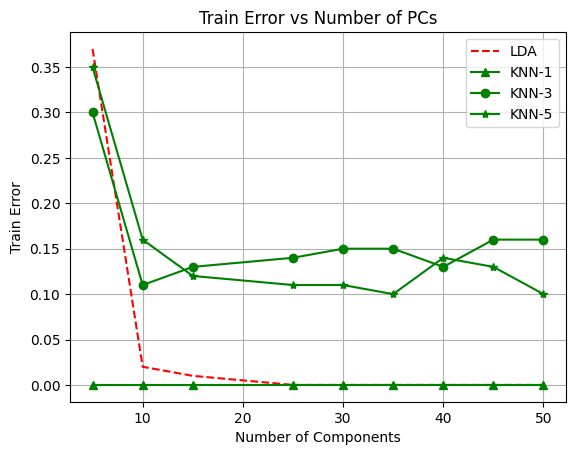

In [37]:
plt.plot(number_comps , LDA_train_error ,'r--' )
plt.plot(number_comps , KNN1_train_error , 'g-^')
plt.plot(number_comps , KNN3_train_error , 'g-o')
plt.plot(number_comps , KNN5_train_error , 'g-*')

plt.legend(['LDA' , 'KNN-1','KNN-3','KNN-5'])
plt.xlabel('Number of Components')
plt.ylabel('Train Error')
plt.title('Train Error vs Number of PCs')
plt.grid()

#### For k=1, training error is zero because if we take a point and determine 1st nearest neighbour it will be the same point in the training dataset so error is zero.

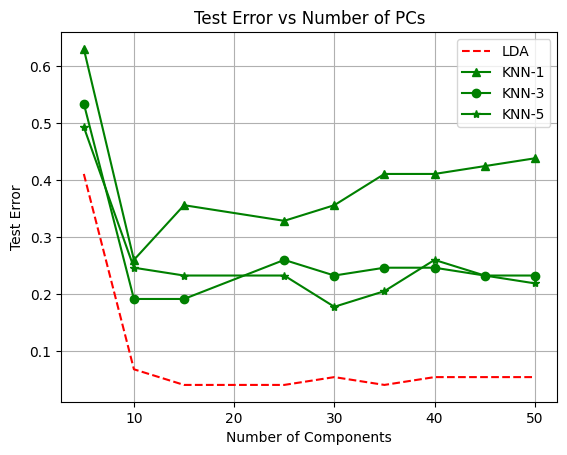

In [38]:
plt.plot(number_comps , LDA_test_error ,'r--' )
plt.plot(number_comps , KNN1_test_error , 'g-^')
plt.plot(number_comps , KNN3_test_error , 'g-o')
plt.plot(number_comps , KNN5_test_error , 'g-*')
plt.xlabel('Number of Components')
plt.ylabel('Test Error')
plt.title('Test Error vs Number of PCs')
plt.legend(['LDA' , 'KNN-1','KNN-3','KNN-5'])
plt.grid()

#### The Error rate (Test and Train) decreases when the number of components increases. Because the information loss decreases when we use more components to reconstruction, After 15th component the Error Rate doesn't change significantly. The LDA model uses Fisher Vectors for Classification, so the Error Rate(both Train and Test) is much less than KNNs.